In [1]:
%load_ext autotime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet121
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

import utils
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
classifier = '3_1_body_part_classifier_40'
base_model = '2_1_submodel_335'

time: 947 µs


In [3]:
model_name = '3_2_ensemble'

time: 5.5 ms


# Initialize model structure

In [4]:
with tf.device('/CPU:0'):
    classifier = models.load_model(f'trained_models/{classifier}.h5')
    classifier = models.Model(input=classifier.layers[-2].inputs[0], output=classifier.layers[-2].outputs[0])
    for mid_layer in classifier.layers:
        mid_layer.trainable = False

    sub_models = []
    for _ in range(7):
        dn121 = DenseNet121(input_tensor=classifier.input, classes=1, weights=None, include_top=False)
        model = models.Model(input=dn121.input, output=layers.Dense(1, activation='sigmoid')(layers.Flatten()(dn121.output)))
        model.load_weights(f'trained_models/{base_model}.h5')
        sub_models.append(model)
        del dn121
        del model
        
    i = 1
    for model in sub_models:
        for mid_layer in model.layers:
            mid_layer.name = str(i) + '_' + mid_layer.name
        i += 1
    for mid_layer in classifier.layers:
        mid_layer.name = 'c_' + mid_layer.name
        
    concat = layers.Concatenate(1)([model.output for model in sub_models])
    dot = layers.Dot(axes=1)([concat, classifier.output])
    
    ensemble = models.Model(input=classifier.input, output=dot)

time: 5min 31s


## lock base layers

In [5]:
for model in sub_models:
    for mid_layer in model.layers:
        mid_layer.trainable = False
        if 'pool4_relu' in mid_layer.name:
            break

time: 3.77 ms


In [6]:
plot_model(ensemble, to_file='ensemble.png')

time: 9.99 s


In [7]:
model = multi_gpu_model(ensemble, gpus=2)

time: 10min 17s


# Prep Data

In [8]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 1.95 s


In [9]:
size = x_train.shape[1]

time: 509 µs


In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 4.02 s


In [11]:
x_train.shape

(36808, 256, 256, 1)

time: 6.74 ms


In [12]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 4.39 ms


In [13]:
datagen.fit(x_train)

time: 3.96 s


# Training

In [17]:
starting_epoch = 0
train_round = 0
batch_size = 32
epochs_per_eval = 10
epochs_per_save = 30
total_epochs = 210
train_history = {'loss': [], 'binary_accuracy': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}

time: 3.55 ms


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
c_7_6_5_4_3_2_1_input_1 (InputL (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           c_7_6_5_4_3_2_1_input_1[0][0]    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           c_7_6_5_4_3_2_1_input_1[0][0]    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            56715790    lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [19]:
# with tf.device('/CPU:0'):
#     ensemble = models.load_model(f'./trained_models/{model_name}_235.h5')
#     model = multi_gpu_model(ensemble, gpus=2)

time: 861 µs


In [20]:
# with open(f'./trained_models/{model_name}_train_history.pkl', 'rb') as pkl_file:
#     train_history = pickle.load(pkl_file)
# with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'rb') as pkl_file:
#     val_per_image_history = pickle.load(pkl_file)
# with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'rb') as pkl_file:
#     val_per_study_history = pickle.load(pkl_file)

time: 1.62 ms


executing epochs 31-40
Epoch 1/10
 - 1254s - loss: 0.3939 - binary_accuracy: 0.8283
Epoch 2/10
 - 1061s - loss: 0.3962 - binary_accuracy: 0.8287
Epoch 3/10
 - 1064s - loss: 0.3954 - binary_accuracy: 0.8283
Epoch 4/10
 - 1060s - loss: 0.3947 - binary_accuracy: 0.8287
Epoch 5/10
 - 1054s - loss: 0.3930 - binary_accuracy: 0.8300
Epoch 6/10
 - 1062s - loss: 0.3930 - binary_accuracy: 0.8283
Epoch 7/10
 - 1058s - loss: 0.3949 - binary_accuracy: 0.8289
Epoch 8/10
 - 1066s - loss: 0.3951 - binary_accuracy: 0.8278
Epoch 9/10
 - 1068s - loss: 0.3921 - binary_accuracy: 0.8284
Epoch 10/10
 - 1065s - loss: 0.3931 - binary_accuracy: 0.8287


INFO:utils.mura_metrics:Accuracy: 0.7857366280888333
INFO:utils.mura_metrics:Kappa: 0.5669514773752171
INFO:utils.mura_metrics:Precision: 0.8494623655913979
INFO:utils.mura_metrics:Recall: 0.6712418300653594


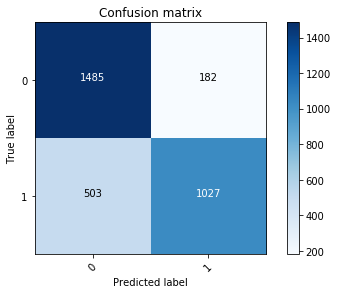

INFO:utils.mura_metrics:Accuracy: 0.7956630525437864
INFO:utils.mura_metrics:Kappa: 0.5756034274767361
INFO:utils.mura_metrics:Precision: 0.8825065274151436
INFO:utils.mura_metrics:Recall: 0.6282527881040892


Valid per image accuracy: 0.7857366280888333
Valid per image kappa: 0.5669514773752171
Valid per image precision: 0.8494623655913979
Valid per image recall: 0.6712418300653594


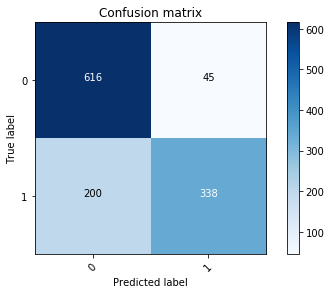

Valid per study accuracy: 0.7956630525437864
Valid per study kappa: 0.5756034274767361
Valid per study precision: 0.8825065274151436
Valid per study recall: 0.6282527881040892
Saving evaluation metrics history...
executing epochs 41-50
Epoch 1/10
 - 1279s - loss: 0.3945 - binary_accuracy: 0.8277
Epoch 2/10
 - 1063s - loss: 0.3925 - binary_accuracy: 0.8299
Epoch 3/10
 - 1065s - loss: 0.3934 - binary_accuracy: 0.8290
Epoch 4/10
 - 1068s - loss: 0.3931 - binary_accuracy: 0.8277
Epoch 5/10
 - 1066s - loss: 0.3930 - binary_accuracy: 0.8288
Epoch 6/10
 - 1059s - loss: 0.3905 - binary_accuracy: 0.8318
Epoch 7/10
 - 1060s - loss: 0.3917 - binary_accuracy: 0.8287
Epoch 8/10
 - 1060s - loss: 0.3907 - binary_accuracy: 0.8281
Epoch 9/10
 - 1065s - loss: 0.3917 - binary_accuracy: 0.8292
Epoch 10/10
 - 1064s - loss: 0.3908 - binary_accuracy: 0.8292


INFO:utils.mura_metrics:Accuracy: 0.7854238348451673
INFO:utils.mura_metrics:Kappa: 0.5663545333284296
INFO:utils.mura_metrics:Precision: 0.8481848184818482
INFO:utils.mura_metrics:Recall: 0.6718954248366014


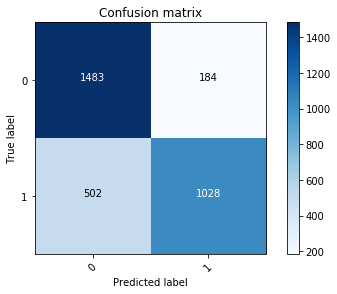

INFO:utils.mura_metrics:Accuracy: 0.7956630525437864
INFO:utils.mura_metrics:Kappa: 0.5757542059192654
INFO:utils.mura_metrics:Precision: 0.8805194805194805
INFO:utils.mura_metrics:Recall: 0.6301115241635687


Valid per image accuracy: 0.7854238348451673
Valid per image kappa: 0.5663545333284296
Valid per image precision: 0.8481848184818482
Valid per image recall: 0.6718954248366014


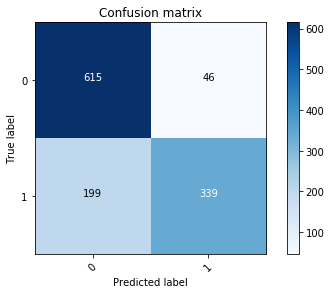

Valid per study accuracy: 0.7956630525437864
Valid per study kappa: 0.5757542059192654
Valid per study precision: 0.8805194805194805
Valid per study recall: 0.6301115241635687
Saving evaluation metrics history...
executing epochs 51-60
Epoch 1/10
 - 1282s - loss: 0.3912 - binary_accuracy: 0.8303
Epoch 2/10
 - 1065s - loss: 0.3890 - binary_accuracy: 0.8302
Epoch 3/10
 - 1060s - loss: 0.3920 - binary_accuracy: 0.8293
Epoch 4/10
 - 1060s - loss: 0.3910 - binary_accuracy: 0.8298
Epoch 5/10
 - 1071s - loss: 0.3896 - binary_accuracy: 0.8301
Epoch 6/10
 - 1060s - loss: 0.3908 - binary_accuracy: 0.8295
Epoch 7/10
 - 1062s - loss: 0.3913 - binary_accuracy: 0.8292
Epoch 8/10
 - 1063s - loss: 0.3909 - binary_accuracy: 0.8297
Epoch 9/10
 - 1065s - loss: 0.3914 - binary_accuracy: 0.8287
Epoch 10/10
 - 1065s - loss: 0.3892 - binary_accuracy: 0.8305


INFO:utils.mura_metrics:Accuracy: 0.7838598686268377
INFO:utils.mura_metrics:Kappa: 0.5631820192406368
INFO:utils.mura_metrics:Precision: 0.8464079273327828
INFO:utils.mura_metrics:Recall: 0.6699346405228758


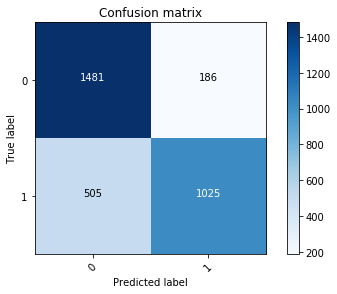

INFO:utils.mura_metrics:Accuracy: 0.7939949958298582
INFO:utils.mura_metrics:Kappa: 0.5722909749471778
INFO:utils.mura_metrics:Precision: 0.8779220779220779
INFO:utils.mura_metrics:Recall: 0.6282527881040892


Valid per image accuracy: 0.7838598686268377
Valid per image kappa: 0.5631820192406368
Valid per image precision: 0.8464079273327828
Valid per image recall: 0.6699346405228758


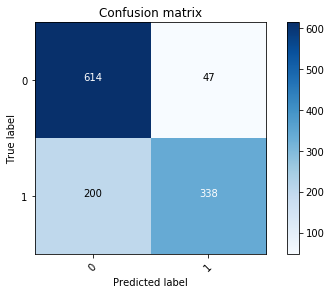

Valid per study accuracy: 0.7939949958298582
Valid per study kappa: 0.5722909749471778
Valid per study precision: 0.8779220779220779
Valid per study recall: 0.6282527881040892
Saving Model to trained_models/3_2_ensemble_60_weights.pkl...
Saving evaluation metrics history...
executing epochs 61-70
Epoch 1/10


KeyboardInterrupt: 

time: 9h 32min 31s


In [35]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    print(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
    if train_round * epochs_per_eval + 1 + starting_epoch <= 30:
        opt = optimizers.Adam()
    else:
        lr = 0.0001 * (0.9 ** train_round)
        opt = optimizers.sgd(lr=lr, momentum=0.9, nesterov=True)
        
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch = len(x_train) / batch_size, epochs=epochs_per_eval, verbose=2)
    
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
        print(f'Valid per image {key}: {per_image_metrics[key]}')
    
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
        print(f'Valid per study {key}: {per_study_metrics[key]}')
    
    cur_epoch = (train_round+1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        print(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}_weights.pkl...')
        weight = model.get_weights() 
        with open(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}_weights.pkl', 'wb') as pkl_file:
            pickle.dump(weight, pkl_file)
#         model.save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    
    print('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1

In [ ]:
# Plots for epochs 1-30
# 1-30 used adam with default parameters
# 236-345 used lr = 0.001 * (0.9 ** train_round)
# 346-365 used lr = 0.0001 * (0.9 ** train_round) (pretty much levelled off, use 335 as result should be good enough)
train_metrics = ['loss', 'binary_accuracy']
validation_metrics = ['accuracy', 'kappa', 'precision', 'recall']

for metric in train_metrics:
    plt.plot(train_history[metric])
plt.title('Training set metrics per epoch')
plt.legend(train_metrics)
plt.show() 

for metric in validation_metrics:
    plt.plot(val_per_image_history[metric])
plt.title(f'Validation set metrics by image per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 

for metric in validation_metrics:
    plt.plot(val_per_study_history[metric])
plt.title(f'Validation set metrics by study per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 